In [2]:
import time
import matplotlib.pyplot as plt

In [38]:
def read_file(filename):
    with open(filename, 'r') as file:
        data = file.read().strip().split()
        numbers = [int(num) for num in data]
        return numbers

In [4]:
def plot_list(numbers):
    plt.plot(numbers)
    plt.show()

In [39]:
filename = r".\data_kaiwu\ppg_data.txt"

number count: 71201
increase count: 71201


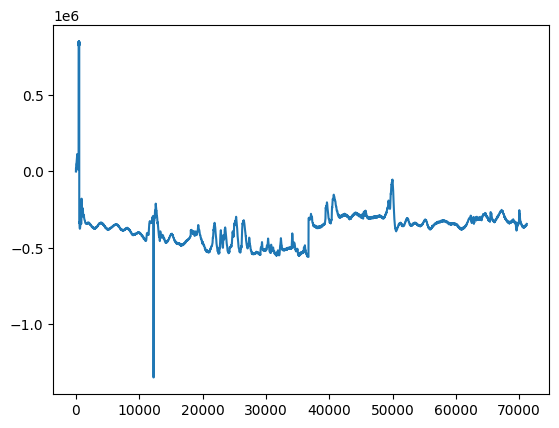

In [6]:
def main():
    pre_count = 0
    # while True:
    if True:
        numbers = read_file(filename)
        cur_count = len(numbers)
        print("number count: " + str(cur_count))
        print("increase count: " + str(cur_count-pre_count))
        pre_count = cur_count
        plot_list(numbers)
        # time.sleep(5)
        
if __name__ == '__main__':
    main()

### ppg数据处理，主要利用pyPPG进行PPG数据的分析

In [97]:
from scipy.signal import medfilt

In [98]:
ppg_data = read_file(filename)

In [99]:
# 首先进行中值滤波，然后再进行带通滤波
filtered_ppg = medfilt(ppg_data, kernel_size=3)
plot_list(filtered_ppg)

NameError: name 'plot_list' is not defined

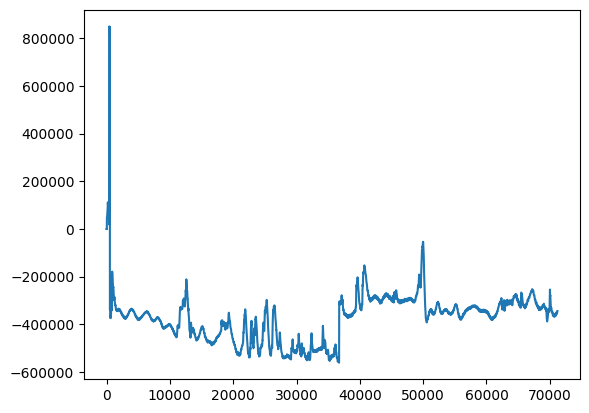

In [11]:
from BaselineRemoval import BaselineRemoval


In [12]:
print(type(ppg_data))

<class 'list'>


In [13]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [73]:
from scipy.fft import fft, ifft

def filter_frequency(ppg_data, fs, low_freq, high_freq):
    # 执行傅里叶变换
    fft_data = fft(ppg_data)
    
    # 获取频率轴
    freqs = np.fft.fftfreq(len(ppg_data), 1/fs)
    
    # 找到感兴趣频率范围的索引
    low_idx = np.argmax(freqs >= low_freq)
    high_idx = np.argmax(freqs >= high_freq)
    
    # 将不在感兴趣频率范围内的频率设置为0
    fft_data_filtered = np.copy(fft_data)
    fft_data_filtered[:low_idx] = 0
    fft_data_filtered[high_idx:] = 0
    
    # 执行逆傅里叶变换得到滤波后的信号
    filtered_signal = np.real(ifft(fft_data_filtered))
    
    return filtered_signal

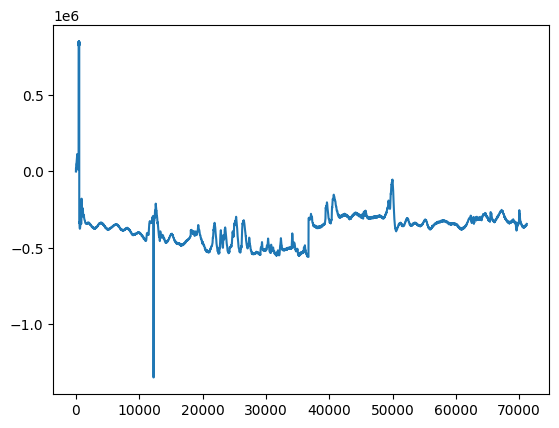

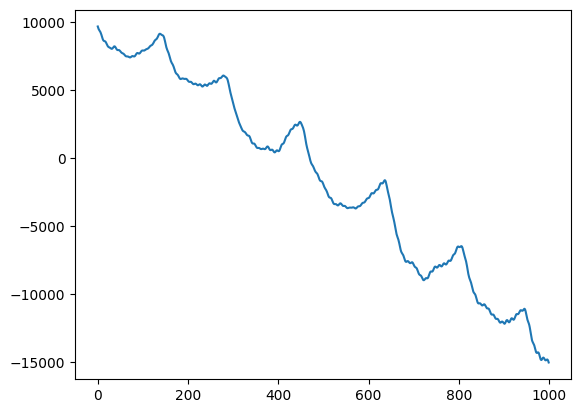

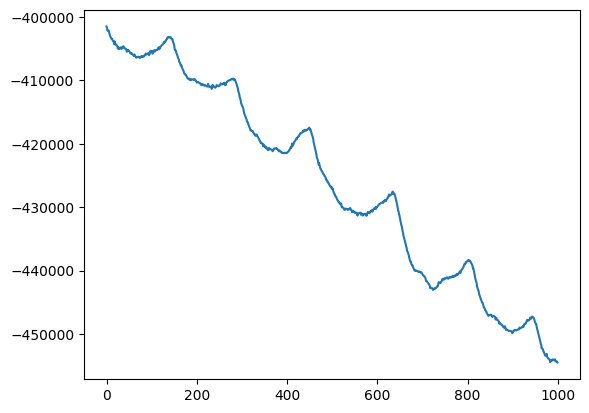

In [48]:
fs = 1000  # 采样频率为1000Hz
low_freq = 0.5  # 感兴趣频率范围的下限
high_freq = 100  # 感兴趣频率范围的上限

plot_list(ppg_data)

# 进行频率滤波
filtered_signal = filter_frequency(ppg_data, fs, low_freq, high_freq)
plot_list(filtered_signal[10000:11000])
plot_list(ppg_data[10000:11000])

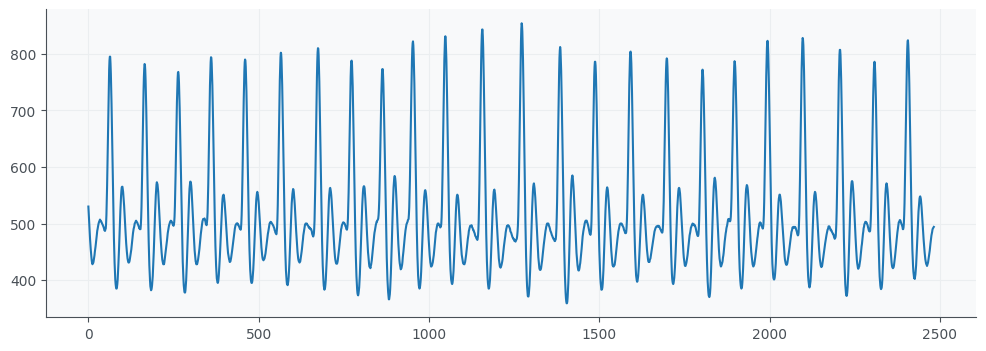

[530. 518. 506. ... 492. 493. 494.]


In [62]:
#first let's load the clean PPG signal
import heartpy as hp
data, timer = hp.load_exampledata(0)

#and visualise
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()
print(data)

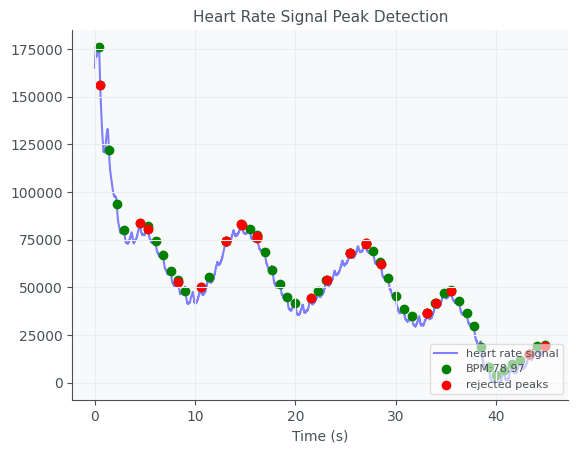

In [64]:
wd, m = hp.process(ppg_data[1000:10000], sample_rate = 200.0)
#call plotter
hp.plotter(wd, m)

In [40]:
ppg_data = read_file(filename)

In [41]:
import numpy as np
from scipy.io import savemat

# 构造示例的PPG数据
sampling_rate = 100  # 采样率为 100 Hz
duration = 60  # 60 秒的信号
# num_samples = sampling_rate * duration
num_samples = len(ppg_data)
time = np.linspace(0, duration, num_samples)
# amplitude = np.sin(2 * np.pi * 1 * time) + 0.5 * np.sin(2 * np.pi * 2 * time)  # 示例信号，可以替换为实际数据

amplitude = ppg_data

# 创建一个包含时间和振幅的字典
ppg_data = {
    'time': time,
    'Data':  amplitude,
    'Fs': 200
}

# 保存为 .mat 文件
savemat('ppg_data.mat', ppg_data)

In [30]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI
import pandas as pd

In [31]:
data_path = "ppg_data.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

In [42]:
# Load the raw PPG signal
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:20*signal.fs] # 20 second long signal to be analysed

In [43]:
print(signal.fs)
print(signal.v)

200
[-2.24000e+02  6.92000e+02  1.00800e+03 ... -3.40169e+05 -3.39791e+05
 -3.39818e+05]


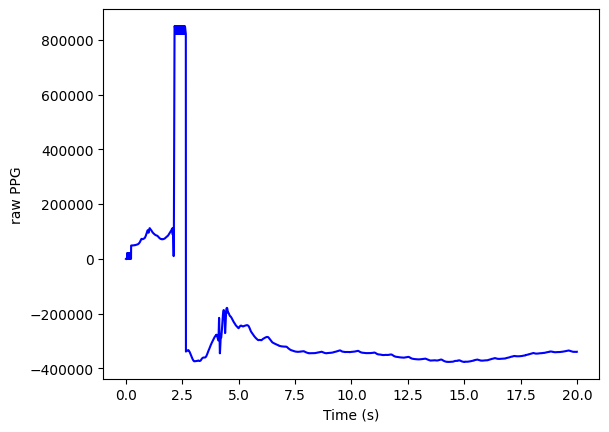

In [44]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

In [45]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

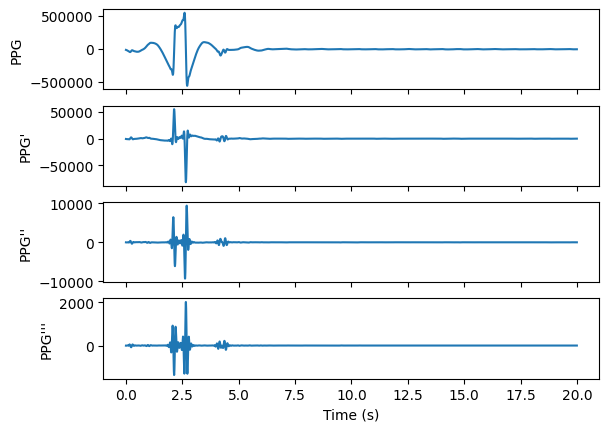

In [49]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

In [50]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

In [51]:
fpex = FP.FpCollection(s=s)

In [52]:
fiducials = fpex.get_fiducials(s=s)

In [53]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                   on    sp    dn    dp   off     u     v     w     a     b  \
Index of pulse                                                               
0                  2   439   543   693   925   427   530   547   419   434   
1                925  1075  1175  1262  1622  1007  1098  1211   997  1016   
2               1622  1732  1774  <NA>  1816  1721  1747  1786  1715  1733   
3               1816  1897  1921  1929  1981  1887  1908  1928  1817  1828   
4               1981  2057  2081  <NA>  2131  2044  2069  2107  2026  2058   
5               2131  2204  2228  <NA>  2276  2194  2216  2234  2166  2179   
6               2276  2353  2378  <NA>  2426  2337  2367  2403  2278  2303   
7               2426  2506  2530  <NA>  2581  2495  2519  2564  2459  2478   
8               2581  2654  2702  2679  2755  2627  2666  2678  2583  2598   
9               2755  2796  2849  2955  3029  2908  2927  2916  2761  2798   
10              3029  3113  3142  <NA>  3200  

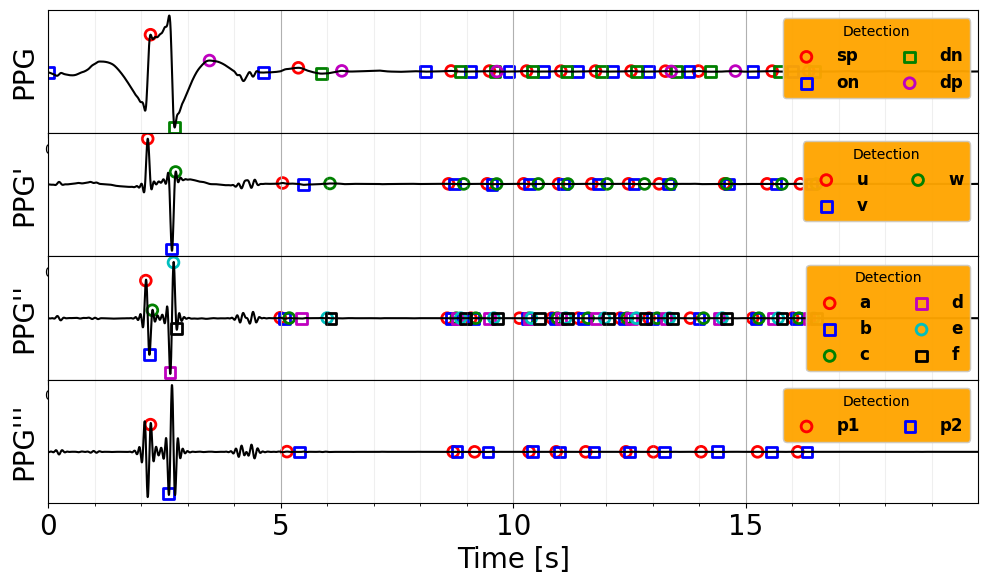

Figure has been saved in the "temp_dir".


In [54]:
# Create a fiducials class
fp = Fiducials(fp=fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

In [58]:
import pyPPG
from scipy.signal import butter, filtfilt

In [61]:
ppg_data = read_file(filename)

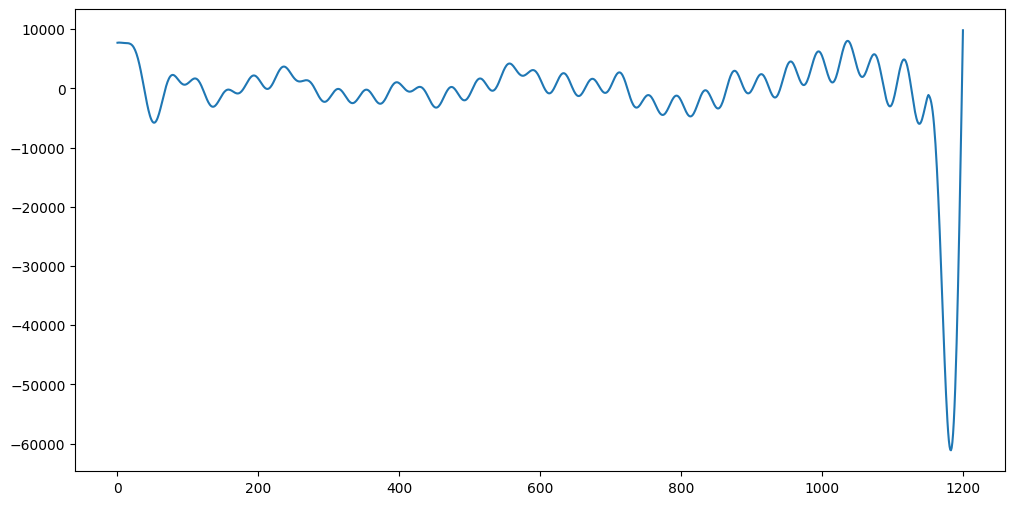

In [94]:
# 定义高通滤波器参数
cutoff_freq = 0.5  # 截止频率为0.5 Hz
# b, a = butter(2, cutoff_freq / (200 / 2), btype='high')


# 应用滤波器
# filtered_ppg = filtfilt(b, a, ppg_data)
filtered_ppg = filter_frequency(ppg_data, 200, 0.5, 5)

# 计算移动平均
window_size = 100
moving_avg = np.convolve(filtered_ppg, np.ones(window_size)/window_size, mode='same')

# 去除漂移
ppg_without_drift = filtered_ppg - moving_avg
plt.figure(figsize=(12, 6))
# plt.plot(ppg_data[10000:11000], label='Original PPG')
plt.plot(ppg_without_drift[70000:72000], label='PPG without drift')
# plt.legend()
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.title('PPG Signal with and without Drift')
# plt.grid(True)
plt.show()

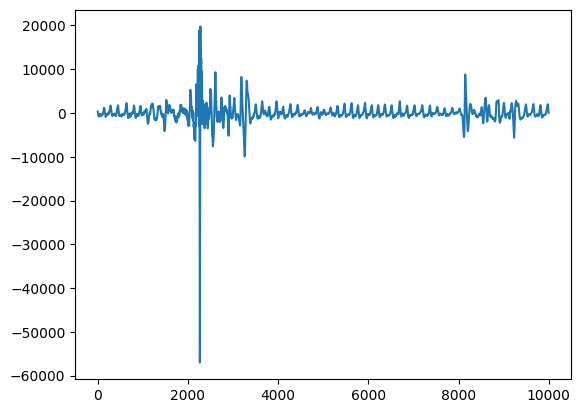

In [76]:
plt.plot(ppg_without_drift[10000:20000], label='PPG without drift')